<a href="https://colab.research.google.com/github/zrtashi/RealEstate/blob/main/RealEstate_Faisalabad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Rent_House Prices in Faisalabad**

In [ ]:
# Import Libaries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
warnings.simplefilter(action="ignore", category=FutureWarning)


# **Data Preprocessing**

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath)
  # Subset to "Faisalabad"
  mask_city = df["city"].str.contains("Faisalabad")
  # Subset to "Flat"
  mask_flat = df["property_type"]=="House"
  # Subset to "Flat"
  mask_rent = df["purpose"]=="For Rent"
  # Subset to "Area"
  mask_area = df["Area Type"]== "Marla"

  # Subset to "Area"
  mask_area_size = df["Area Size"] < 10


  df = df[mask_city & mask_flat & mask_rent & mask_area & mask_area]

  # Remove outliers for "price"
  high = df["price"].quantile(0.9)
  mask_price = df["price"]<= high
  df = df[mask_price]

  # Drop "low and high" cardinility columns
  df.drop(columns=["property_id","page_url", "city", "property_type","province_name", "purpose", "Area Category"], inplace=True)
  # drop leaky column
  df.drop(columns=["location_id"], inplace=True)
  # Drop multicollinearlity features
  df.drop(columns=["baths", "bedrooms"], inplace=True)

  # Drop features with  null counts
  df.drop(columns=["agency","agent"], inplace=True)
  # Drop irrevent column
  df.drop(columns=["date_added","area"], inplace= True)

  return df
# Read CSV file
df = wrangle("/content/zameen-updated.csv")

In [ ]:
df.shape

(1911, 6)

In [ ]:
df.head()

,price,location,latitude,longitude,Area Type,Area Size
1874,12000,Shahzad Colony,31.395879,73.111181,Marla,3.0
1875,10000,Peoples Colony No 2,31.395993,73.106961,Marla,3.0
1876,13000,Peoples Colony No 2,31.395993,73.106961,Marla,3.0
2188,25000,Satiana Road,31.378610,73.129245,Marla,3.0
2192,17000,Younas Town,31.382585,73.123012,Marla,3.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1911 entries, 1874 to 164946
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      1911 non-null   int64  
 1   location   1911 non-null   object 
 2   latitude   1911 non-null   float64
 3   longitude  1911 non-null   float64
 4   Area Type  1911 non-null   object 
 5   Area Size  1911 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 104.5+ KB


Text(0.5, 1.0, 'Distribution of Houses Sizes')

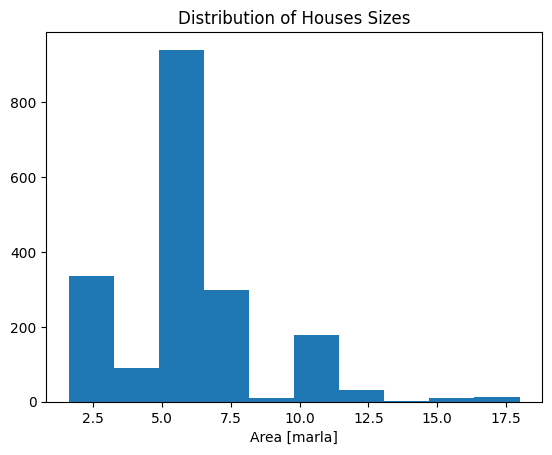

In [ ]:
# Create a histogram of the "Area Size" column in the DataFrame
plt.hist(df["Area Size"])

# Label the x-axis as "Area [marla]"
plt.xlabel("Area [marla]")

# Add a title to the histogram indicating that it shows the distribution of house sizes
plt.title("Distribution of House Sizes")


Text(0.5, 1.0, 'Distribution of Houses Sizes')

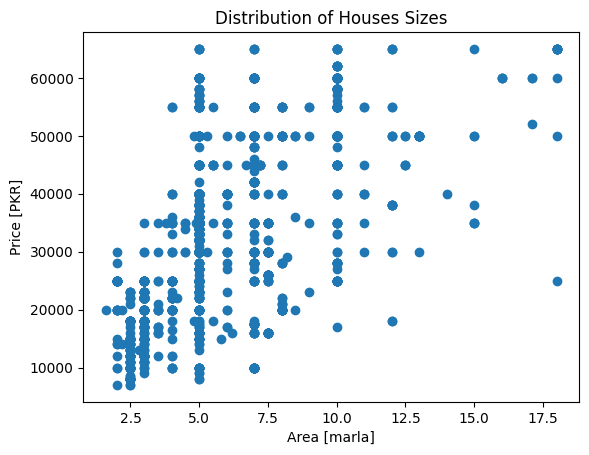

In [ ]:
# Create a scatter plot with "Area Size" on the x-axis and "price" on the y-axis
plt.scatter(x=df["Area Size"], y=df["price"])

#xaxis label
plt.xlabel("Area [marla]")
#yaxis label
plt.ylabel("Price [PKR]")

# title
plt.title("Distribution of Houses Sizes")

In [ ]:
df.describe()["price"]

,price
count,1911.000000
mean,33085.075877
std,13251.123528
min,7000.000000
25%,23000.000000
50%,35000.000000
75%,40000.000000
max,65000.000000


<Axes: >

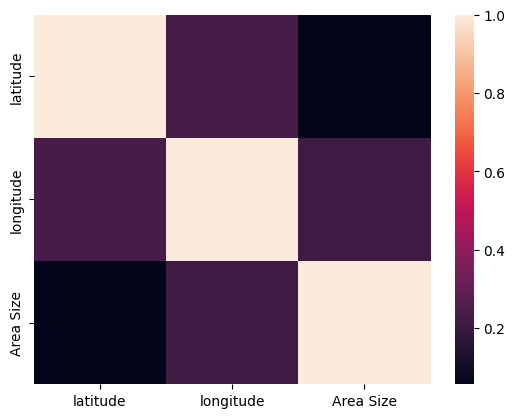

In [ ]:
# Select only the numerical columns from the DataFrame, excluding the "price" column
corr = df.select_dtypes("number").drop(columns=["price"]).corr()

# Create a heatmap to visualize the correlation matrix of the selected numerical columns
sns.heatmap(corr)


In [ ]:
# Create a scatter plot on a map using the DataFrame
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="latitude",  # Latitude coordinates for the map
    lon="longitude",  # Longitude coordinates for the map
    width=600,  # Set the width of the map to 600 pixels
    height=600,  # Set the height of the map to 600 pixels
    color="price",  # Color the points based on the "price" column
    hover_name="location",  # Display the "location" as the main hover text
    hover_data=["Area Type"],  # Display the "Area Type" in the hover tooltip
)

# Update the layout to use the OpenStreetMap style for the map
fig.update_layout(mapbox_style="open-street-map")

# Display the map
fig.show()


#**Split Data for training model**


In [ ]:
# Define the features (independent variables) to be used for training the model
features = ['location', 'latitude', 'longitude', 'Area Type', 'Area Size']

# Define the target (dependent variable) we want to predict
target = "price"

# Create the training set by selecting the features from the DataFrame
X_train = df[features]

# Create the target set by selecting the target column from the DataFrame
y_train = df[target]


In [ ]:
# Calculate the mean (average) of the target variable "price" in the training set
y_mean = y_train.mean()

# Display the calculated mean value
y_mean


33085.075876504445

In [ ]:
# Create a baseline prediction by assuming every predicted price is the mean price
y_pred_baseline = [y_mean] * len(y_train)

# Calculate the Mean Absolute Error (MAE) between the actual prices and the baseline predictions
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)

# Print the mean price, rounded to two decimal places
print("Mean price:", y_mean.round(2))

# Print the baseline MAE to evaluate the baseline model's performance

print("Baseline MAE:", baseline_mae.round(2))

Mean price: 33085.08
Baseline MAE: 10357.86


In [ ]:
# Build a machine learning pipeline with one-hot encoding and Ridge regression
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),  # Encode categorical features as one-hot (binary) variables
    Ridge()  # Use Ridge regression as the model
)

# Fit the model to the training data (X_train and y_train)
model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['location', 'Area Type'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [ ]:
# Generate predictions for the training data using the fitted model
y_pred_training = model.predict(X_train)

# Display the first 5 predictions
y_pred_training[:5]


array([16314.33936336, 17209.21224808, 17209.21224808, 17460.96640445,
       26773.53929274])

In [ ]:
# Calculate the Mean Absolute Error (MAE) between the actual and predicted prices on the training set
mae = mean_absolute_error(y_train, y_pred_training)

# Print the training MAE to evaluate the model's performance on the training data
print("Training MAE:", mae)


Training MAE: 5102.510832813096


In [ ]:
# Load the test dataset from a CSV file into a DataFrame
X_test = pd.read_csv("/content/test_houses.csv")

# Display the contents of the test DataFrame
X_test


,location,latitude,longitude,Area Type,Area Size
0,Shahzad Colony,31.395879,73.111181,Marla,3.0
1,Peoples Colony No 2,31.395993,73.106961,Marla,3.0
2,Peoples Colony No 2,31.395993,73.106961,Marla,3.0
3,Satiana Road,31.378610,73.129245,Marla,3.0
4,Younas Town,31.382585,73.123012,Marla,3.0
...,...,...,...,...,...
1906,Eden Gardens,31.424316,73.149465,Marla,10.0
1907,Canal Road,31.429527,73.155627,Marla,5.0
1908,Canal Road,31.429527,73.155627,Marla,5.0
1909,Canal Road,31.429527,73.155627,Marla,7.0


In [ ]:
# Use the fitted model to make predictions on the test data
y_pred_test = pd.Series(model.predict(X_test))

# Display the first 5 predicted values for the test data
y_pred_test.head()

,0
0,16314.339363
1,17209.212248
2,17209.212248
3,17460.966404
4,26773.539293


In [ ]:
# coefficients = model.named_steps["ridge"].coef_
# features = model.named_steps["onehotencoder"].get_feature_names()
# feat_imp = pd.Series(coefficients, index=features)
# feat_imp.head()

In [ ]:
# # Build bar chart
# feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
# plt.xlabel("Price")
# plt.ylabel("Feature")
# plt.title("Feature Importance for houses Price");

In [ ]:
def make_prediction(location, latitude, longitude, area_type, area_size):
    # Create a DataFrame with the input features
    data = {
        "location": location,
        "latitude": latitude,
        "longitude": longitude,
        "Area Type": area_type,
        "Area Size": area_size,
    }
    # Create a DataFrame with a single row of data from the input features
    df = pd.DataFrame(data, index=[0])

    # Use the trained model to make a prediction based on the input features
    prediction = model.predict(df).round(2)[0]

    # Return the predicted property price formatted as a string
    return f"Predicted property price: Rs{prediction}"


In [ ]:
# Create interactive widgets for making predictions using the make_prediction function
interact(
    make_prediction,  # Function to call with the interactive widgets' values

    # Slider for selecting area size with a range based on training data
    area_size=IntSlider(
        min=X_train["Area Size"].min(),  # Minimum value based on training data
        max=X_train["Area Size"].max(),  # Maximum value based on training data
        value=X_train["Area Size"].mean(),  # Default value as the mean of the training data
    ),

    # Slider for selecting latitude with a range based on training data
    latitude=FloatSlider(
        min=X_train["latitude"].min(),  # Minimum value based on training data
        max=X_train["latitude"].max(),  # Maximum value based on training data
        step=0.01,  # Step size for the slider
        value=X_train["latitude"].mean(),  # Default value as the mean of the training data
    ),

    # Slider for selecting longitude with a range based on training data
    longitude=FloatSlider(
        min=X_train["longitude"].min(),  # Minimum value based on training data
        max=X_train["longitude"].max(),  # Maximum value based on training data
        step=0.01,  # Step size for the slider
        value=X_train["longitude"].mean(),  # Default value as the mean of the training data
    ),

    # Dropdown for selecting location with options from unique values in training data
    location=Dropdown(options=sorted(X_train["location"].unique())),

    # Dropdown for selecting area type with options from unique values in training data
    area_type=Dropdown(options=sorted(X_train["Area Type"].unique()))
);


interactive(children=(Dropdown(description='location', options=('204 Chak Road', 'Abbaspur', 'Abdullahpur', 'A…